In [1]:
UP = 'up'
DOWN = 'down'
LEFT = 'left'
RIGHT = 'right'
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from cvxopt import solvers, matrix

In [2]:
"""
Reward Function 1
"""



class RF1:
    def __init__(self):
        self.reward = np.zeros([10, 10])
        self.reward[2, 5]  = -10
        self.reward[2, 6]  = -10
        self.reward[3,5] = -10
        self.reward[3,6] = -10
        
        self.reward[4, 1] = -10
        self.reward[4, 2] = -10
        self.reward[5, 1] = -10
        self.reward[5, 2] = -10
        
        self.reward[8, 2] = -10
        self.reward[8, 3] = -10
        self.reward[9, 2] = -10
        self.reward[9, 3] = -10
        
        self.reward[9, 9] = 1.0

    def get_reward(self,):
        return self.reward

class RF2:
    def __init__(self):
        self.reward = np.zeros([10, 10])
        self.reward[9, 9] = 10.0
        for i in range(1, 7):
            self.reward[i, 4] = -100.0
        self.reward[1, 5] = -100.0
        self.reward[1, 6] = -100.0
        self.reward[2, 6] = -100.0
        self.reward[3, 6] = -100.0
        self.reward[3, 7] = -100.0
        self.reward[3, 8] = -100.0
        self.reward[4, 8] = -100.0
        self.reward[5, 8] = -100.0
        self.reward[6, 8] = -100.0
        self.reward[7, 8] = -100.0
        self.reward[7, 7] = -100.0
        self.reward[7, 6] = -100.0
        self.reward[8, 6] = -100.0
    
    def get_reward(self,):
        return self.reward

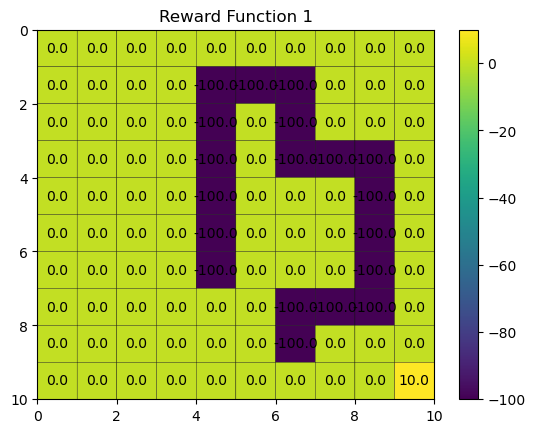

In [3]:
plt.pcolor(RF2().get_reward(), edgecolors='black')
plt.title("Reward Function 1")
for (j,i),label in np.ndenumerate(RF2().get_reward()):
  plt.text(i+0.5, j+0.5, label, ha='center', va='center')
plt.gca().invert_yaxis()
plt.colorbar()
plt.show()

In [5]:

class Environment:
    
    def __init__(self, size, actions, omega, gamma):
        self.size = size
        self.omega = omega
        self.gamma = gamma
        self.actions = actions
        self.P = self.find_p()

    def is_out(self, x, y):
        if x < 0 or x >= 10:
            return True
        if y < 0 or y >= 10:
            return True
        return False

    def get_direction(self, action):
        if action == UP:
            return -1, 0
        if action == DOWN:
            return 1, 0
        if action == LEFT:
            return 0, -1
        if action == RIGHT:
            return 0, 1

    def find_p(self):
        size = self.size
        res = np.zeros((4, size, size))
        count = 0
        for action in self.actions.keys():
            p_i = np.zeros((size, size))
            grid = np.zeros((int(size/10), int(size/10)))
            for i in range(grid.shape[0]):
                for j in range(grid.shape[1]):
                    prob = self.get_neighbor_p(i, j, action)
                    for k in prob:
                        p_i[(i+j*10), k] = prob[k]
            res[count] = p_i
            count += 1
        return res

    def get_neighbor_p(self, x, y, action):
        omega = float(self.omega / 4)
        states = [omega, omega, omega, omega, 0]
        states[self.actions[action]] += 1 - self.omega
        res = {}
        for a in self.actions:
            dx, dy = self.get_direction(a)
            if self.is_out(x + dx, y + dy):
                states[4] += states[self.actions[a]]
                states[self.actions[a]] = 0

        for a in self.actions:
            dx, dy = self.get_direction(a)
            if not self.is_out(x + dx, y + dy):
                key = (x + dx) + (y + dy) * 10
                value = states[self.actions[a]]
                res[key] = value
        res[x + y * 10] = states[4]
        return res

    def get_p(self):
        return self.P

In [6]:
# create a state_space for mapping of states numbering and coordinate
num_states = 100
state_space = dict()
for i in range(num_states):
  row = i % 10
  col = i // 10
  state_space[i] = (row, col)

# action set
num_acts = 4
# act_sets = np.array(["right", "left", "up", "down"])
act_sets = np.array([RIGHT, LEFT, UP, DOWN])

# reward function (#1) in 1D
rwd = RF1().get_reward().flatten("F")

# discount factor
gamma = 0.8

# transition probabilities matrix with probability w 
w = 0.1
actions = {UP: 0, DOWN: 1, LEFT: 2, RIGHT: 3}
env = Environment(size = num_states, actions=actions , omega=w, gamma=gamma)
tp = env.get_p()

In [8]:
"""
Implement the Initialization (lines 2-4) and 
Estimation (lines 5-13) steps of the Value Iteration algorithm
"""

# create an optimal state-value function
def optimal_state_value_function(tp, rwd, state_space, actions, gamma, epsilon):
  # init
  vs = np.zeros(len(state_space))
  delta = np.inf
  num_steps = 0
  prev_vs = np.copy(vs)
  policy = np.zeros(len(state_space))
  # print(actions)
  while delta > epsilon:
    delta = 0
    for i in range(len(state_space)):
      vs[i] = max([np.sum(tp[actions[act]][i]*(rwd + gamma*prev_vs)) for act in actions.keys()])
      delta = max(delta, abs(prev_vs[i] - vs[i]))
    prev_vs = np.copy(vs)
    num_steps += 1
    
  for i in range(len(state_space)):
    policy[i] = np.argmax([np.sum(tp[actions[act]][i]*(rwd + gamma*vs)) for act in actions.keys()])
  return vs, num_steps, policy

Number of steps needed to converge:  22


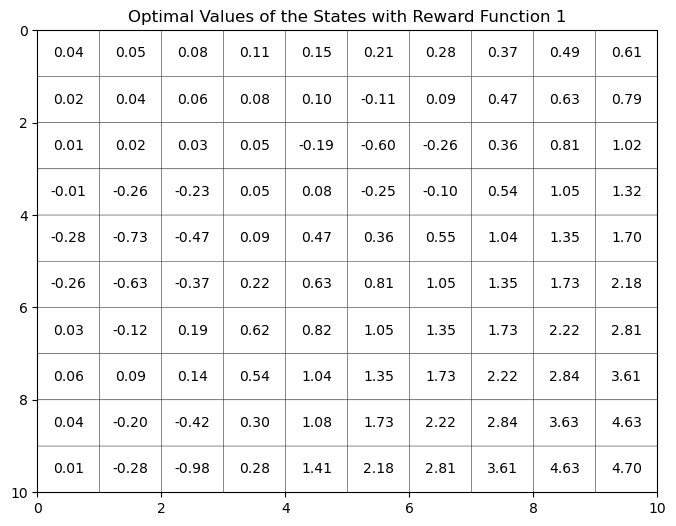

In [9]:
epsilon = 0.01
V_opt, num_steps, _ = optimal_state_value_function(tp, rwd, state_space, actions, gamma, epsilon)

# report
print("Number of steps needed to converge: ", num_steps)
# plot
plt.figure(figsize=(8, 6))
plt.pcolor(V_opt.reshape((10, 10)).T, edgecolors='black', cmap=ListedColormap(['white']))
plt.title("Optimal Values of the States with Reward Function 1")
for (j, i), label in np.ndenumerate(V_opt.reshape((10, 10)).T):
  plt.text(i+0.5, j+0.5, '{:.2f}'.format(label), ha='center', va='center')
plt.gca().invert_yaxis()
# plt.colorbar()
plt.show()

In [13]:
def irl(P_exp, tp, R_max, state_space, act_sets, gamma, lambda_, actions ):
  # parameter
  num_states = len(state_space)
  num_acts = len(act_sets)

  # init 
  I = np.identity(num_states)
  Z = np.zeros((num_states, num_states))
  P_a1 = np.zeros((num_states, num_states))
  P_as = np.zeros((3, num_states, num_states))
  D = None 

  # get P_a1 and P_as
  for i in range(len(P_exp)):
    policy_direction = act_sets[int(P_exp[i])]
    P_a1[i, :] = tp[actions[policy_direction]][i]
    other_actions = np.setdiff1d(range(num_acts), P_exp[i])
    for j, a in enumerate(other_actions):
      P_as[j, i, :] = tp[actions[act_sets[a]]][i]

  # get c, D, b matrices
  for i in range(num_acts-1):
    P_a = P_as[i]
    temp = np.hstack((I, Z, np.matmul(P_a - P_a1, np.linalg.inv(I - gamma*P_a1))))
    temp = np.vstack((temp, 
                      np.hstack((Z, Z, np.matmul(P_a - P_a1, np.linalg.inv(I - gamma*P_a1))))))
    if D is None:
      D = temp
    else:
      D = np.vstack((temp, D))
      
  # compute D, b, c
  D = np.vstack((D,
                  np.hstack((Z, -I, I)), 
                  np.hstack((Z, -I, -I)),
                  np.hstack((Z, Z, I)),
                  np.hstack((Z, Z, -I))))

  b = np.vstack((np.zeros(((num_acts-1)*num_states, 1)), 
                  np.zeros(((num_acts-1)*num_states, 1)), 
                  np.zeros((num_states, 1)), 
                  np.zeros((num_states, 1)), 
                  R_max*np.ones((num_states, 1)),
                  R_max*np.ones((num_states, 1))))

  c = np.vstack((np.ones((num_states, 1)),
                  -lambda_*np.ones((num_states, 1)), 
                  np.zeros((num_states, 1))))

  # compute R
  solvers.options['show_progress']=False
  sol = solvers.lp(-matrix(c), matrix(D), matrix(b))
  R = np.array(sol['x'][-100:]).squeeze()

  return c, D, b, R


def accuracy(exp_pol, ag_pol):
  return np.sum(exp_pol == ag_pol) / len(exp_pol)

In [19]:
# env setup with reward function 1 and w = 0.1
num_states = 100
state_space = dict()
for i in range(num_states):
  row = i % 10
  col = i // 10
  state_space[i] = (row, col)
num_acts = 4
act_sets = np.array(['up', 'down', 'left', 'right'])
rwd = RF1().get_reward().flatten("F")
R_max = rwd.max()
gamma = 0.8
epsilon = 0.01
w = 0.1
actions = {'up': 0, 'down': 1, 'left': 2, 'right': 3}
env = Environment(size = num_states, actions=actions , omega=w, gamma=gamma)
tp = env.get_p()

# get GT optimal policy from expert [P_opt] based on reward function 1
V_exp, num_steps_exp, P_exp = optimal_state_value_function(tp, rwd, state_space, actions, gamma, epsilon)

In [20]:
'''
Sweep λ from 0 to 5, and compute the IRL accuracy
'''
lambdas = np.linspace(0, 5, 500)
accs = []
for lambda_ in lambdas:
  c, D, b, extracted_rwd = irl(P_exp, tp, R_max, state_space, act_sets, gamma, lambda_, actions)
  V_agent, num_steps_agent, P_agent = optimal_state_value_function(tp, extracted_rwd, state_space, 
                                                              actions, gamma, epsilon)
  accs.append(accuracy(P_exp, P_agent))

In [18]:
import os
fig_path = "figs"
os.makedirs(fig_path, exist_ok=True)
plt.plot(lambdas, accs)
plt.xlabel("λ")
plt.ylabel("Accuracy")
plt.title("Accuracy of Agent Actions based on IRL (RF1)")
plt.grid()
plt.savefig(os.path.join(fig_path, "q11.png"))
plt.show()

NameError: name 'accs' is not defined

In [86]:
max_acc = max(accs)
print("index of the max accuracy: ", accs.index(max_acc))
print("corresponding lambda: ", lambdas[accs.index(max_acc)])

print("max accuracy: ", max_acc)

index of the max accuracy:  75
corresponding lambda:  0.751503006012024
max accuracy:  0.95


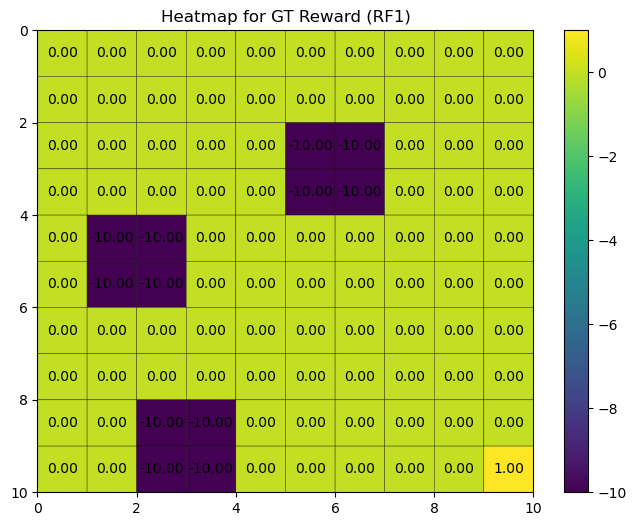

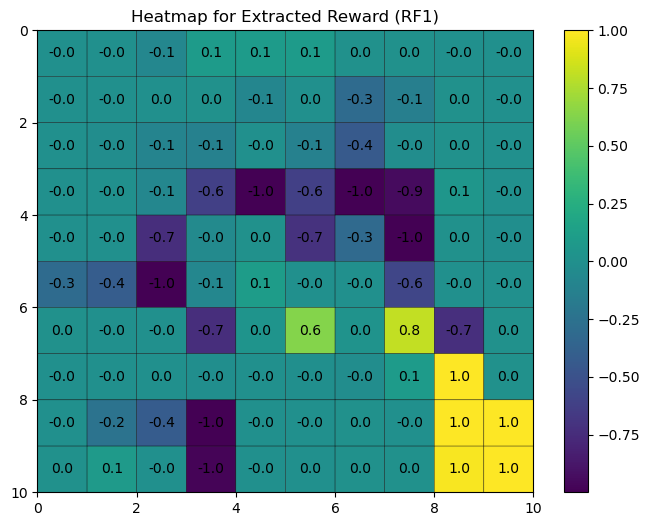

In [110]:
max_lambda1 = lambdas[accs.index(max_acc)]
c, D, b, extracted_rwd1 = irl(P_exp, tp, R_max, state_space, act_sets, gamma, max_lambda1, actions)
rf1 = RF1().get_reward()

plt.figure(figsize=(8, 6))
plt.pcolor(rf1, edgecolors='black')
plt.title("Heatmap for GT Reward (RF1)")
for (j,i),label in np.ndenumerate(rf1):
  plt.text(i+0.5, j+0.5, "{:.2f}".format(label), ha='center', va='center')
plt.gca().invert_yaxis()
plt.colorbar()
plt.savefig(os.path.join(fig_path, "q13_1.png"))
plt.show()

plt.figure(figsize=(8, 6))
plt.pcolor(extracted_rwd1.reshape((10, 10)).T, edgecolors='black')
plt.title("Heatmap for Extracted Reward (RF1)")
for (j,i),label in np.ndenumerate(extracted_rwd1.reshape((10, 10)).T):
  plt.text(i+0.5, j+0.5, "{:.1f}".format(label), ha='center', va='center')
plt.gca().invert_yaxis()
plt.colorbar()
plt.savefig(os.path.join(fig_path, "q13_2.png"))
plt.show()

Number of steps needed to converge: 32



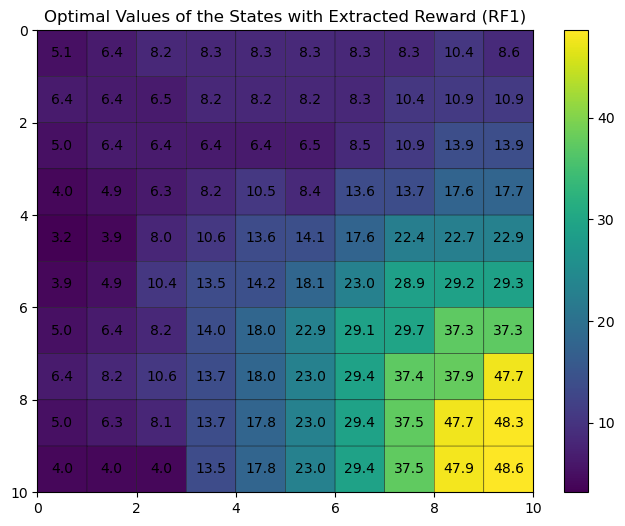

In [76]:
V_agent_1, num_steps_1, _ = optimal_state_value_function(tp, extracted_rwd1, state_space, 
                                                              actions, gamma, epsilon)

# report
print("Number of steps needed to converge: {}\n".format(num_steps_1))
# plot
plt.figure(figsize=(8, 6))
plt.pcolor(V_agent_1.reshape((10, 10)).T, edgecolors='black')
plt.title("Optimal Values of the States with Extracted Reward (RF1)")
for (j, i), label in np.ndenumerate(V_agent_1.reshape((10, 10)).T):
  plt.text(i+0.5, j+0.5, '{:.1f}'.format(label), ha='center', va='center')
plt.gca().invert_yaxis()
plt.colorbar()
plt.savefig(os.path.join(fig_path, "q14.png"))
plt.show()

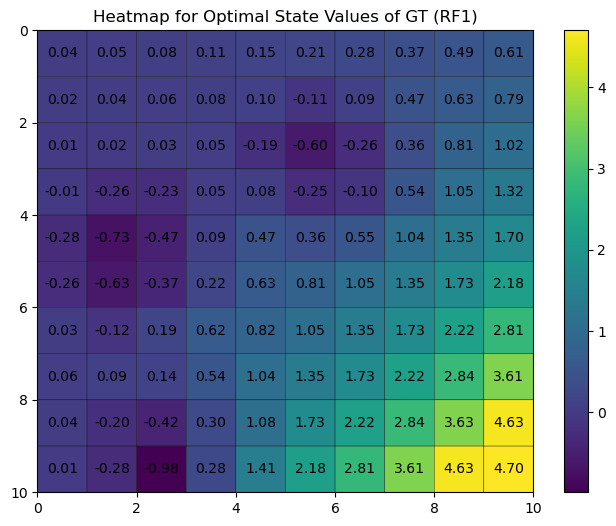

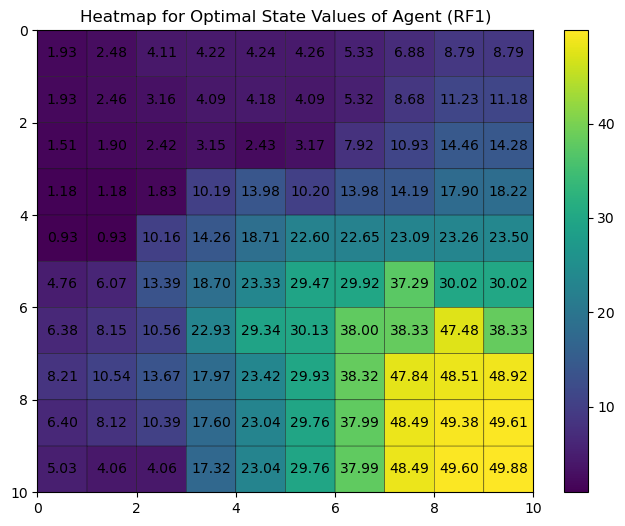

In [105]:
V_agent_1, num_steps_1, _ = optimal_state_value_function(tp, extracted_rwd1, state_space, 
                                                              actions, gamma, epsilon)

# plot
plt.figure(figsize=(8, 6))
plt.pcolor(V_exp.reshape((10, 10)).T, edgecolors='black')
plt.title("Heatmap for Optimal State Values of GT (RF1)")
for (j, i), label in np.ndenumerate(V_exp.reshape((10, 10)).T):
  plt.text(i+0.5, j+0.5, '{:.2f}'.format(label), ha='center', va='center')
plt.gca().invert_yaxis()
plt.colorbar()
plt.savefig(os.path.join(fig_path, "q15_1.png"))
plt.show()

# plot
plt.figure(figsize=(8, 6))
plt.pcolor(V_agent_1.reshape((10, 10)).T, edgecolors='black')
plt.title("Heatmap for Optimal State Values of Agent (RF1)")
for (j, i), label in np.ndenumerate(V_agent_1.reshape((10, 10)).T):
  plt.text(i+0.5, j+0.5, '{:.2f}'.format(label), ha='center', va='center')
plt.gca().invert_yaxis()
plt.colorbar()
plt.savefig(os.path.join(fig_path, "q15_2.png"))
plt.show()

In [10]:
def plot_arrow_diff(P_agent, P_exp, state_space, title):
    diff_idx = np.where(P_agent != P_exp)[0]
    diff_coor = [state_space[i] for i in diff_idx]
    action_matrix = P_agent.reshape((10, 10)).T

    _, ax = plt.subplots()
    num_rows = len(action_matrix)
    min_val, max_val = 0, num_rows

    for i in range(num_rows):
        for j in range(num_rows):
            c = action_matrix[i][j]
            arrow = ''
            if(c == 3):
                arrow = u'→'
            elif(c == 2):
                arrow = u'←'
            elif(c == 0):
                arrow = u'↑'
            else:
                arrow = u'↓' 
            
            if (i, j) in diff_coor:
              ax.text(j + 0.5, i + 0.5, arrow, va='center', ha='center', color='red')
            else:
              ax.text(j + 0.5, i + 0.5, arrow, va='center', ha='center', color='blue')

    ax.set_xlim(min_val, max_val)
    ax.set_ylim(max_val, min_val)
    ax.set_xticks(np.arange(max_val))
    ax.set_yticks(np.arange(max_val))
    ax.set_title(title)
    ax.xaxis.tick_top()
    ax.grid()

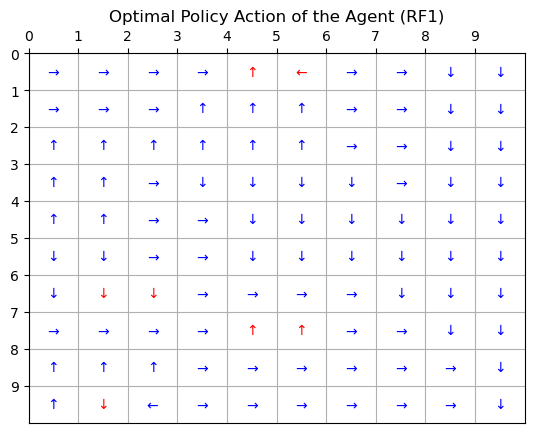

In [111]:
# get optimal policy based on extracted reward

_, _,  P_agent1 = optimal_state_value_function(tp, extracted_rwd1, state_space, 
                                                              actions, gamma, epsilon)

# get optimal policy based on GT reward
rf1_ = RF1().get_reward().flatten("F")
_, _,  P_exp1 = optimal_state_value_function(tp, rf1_, state_space, 
                                                              actions, gamma, epsilon)

# make plot
title = "Optimal Policy Action of the Agent (RF1)"
plot_arrow_diff(P_agent1, P_exp1, state_space, title)
plt.savefig(os.path.join(fig_path, "q16.png"))

In [14]:
# env setup with reward function 1 and w = 0.1
num_states = 100
state_space = dict()
for i in range(num_states):
  row = i % 10
  col = i // 10
  state_space[i] = (row, col)
num_acts = 4
act_sets = np.array(['up', 'down', 'left', 'right'])
rwd2 = RF2().get_reward().flatten("F")
R_max = rwd2.max()
gamma = 0.8
epsilon = 0.01
w = 0.1
actions = {'up': 0, 'down': 1, 'left': 2, 'right': 3}
env = Environment(size = num_states, actions=actions , omega=w, gamma=gamma)
tp = env.get_p()

# get GT optimal policy from expert [P_opt] based on reward function 1
V_exp, num_steps_exp, P_exp2 = optimal_state_value_function(tp, rwd2, state_space, actions, gamma, epsilon)
'''
Sweep λ from 0 to 5, and compute the IRL accuracy
'''
lambdas = np.linspace(0, 5, 500)
accs2 = []
for lambda_ in lambdas:
  c, D, b, extracted_rwd = irl(P_exp2, tp, R_max, state_space, act_sets, gamma, lambda_, actions)
  V_agent, num_steps_agent, P_agent = optimal_state_value_function(tp, extracted_rwd, state_space, 
                                                              actions, gamma, epsilon)
  accs2.append(accuracy(P_exp2, P_agent))

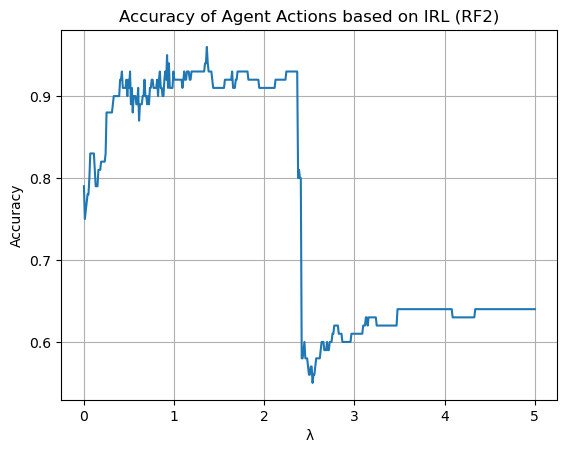

In [30]:
plt.plot(lambdas, accs2)
plt.xlabel("λ")
plt.ylabel("Accuracy")
plt.title("Accuracy of Agent Actions based on IRL (RF2)")
plt.grid()
plt.savefig(os.path.join(fig_path, "q18.png"))
plt.show()

In [16]:
max_acc2 = max(accs2)
print("index of the max accuracy: ", accs2.index(max_acc2))
print("corresponding lambda: ", lambdas[accs2.index(max_acc2)])
print("max accuracy: ", max_acc2)

index of the max accuracy:  136
corresponding lambda:  1.3627254509018036
max accuracy:  0.96


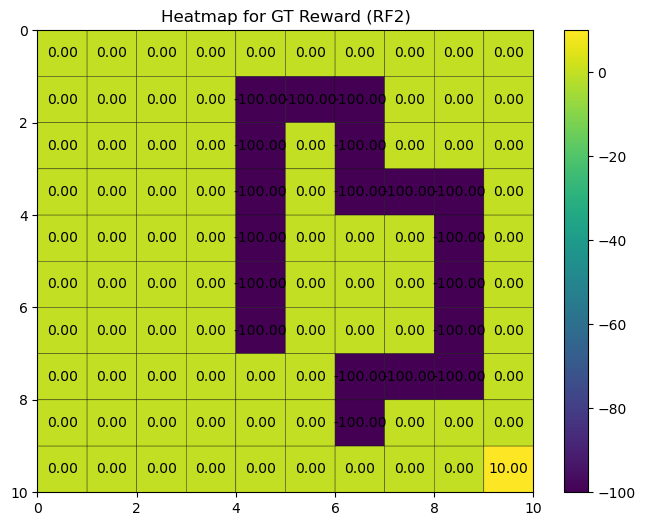

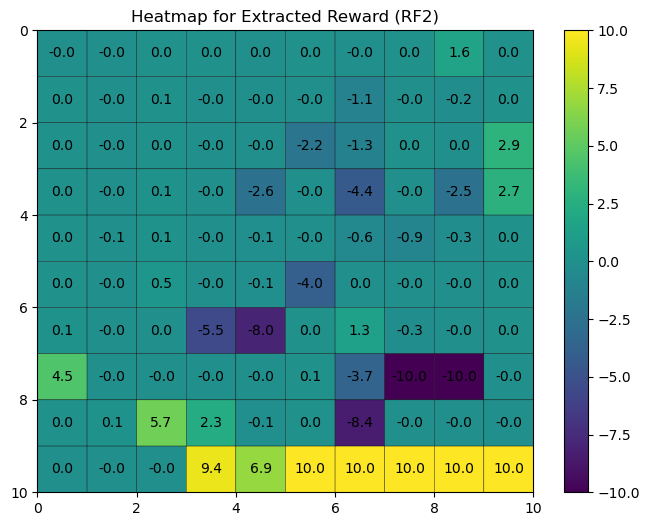

In [19]:
max_lambda2 = lambdas[accs2.index(max_acc2)]
c, D, b, extracted_rwd2 = irl(P_exp2, tp, R_max, state_space, act_sets, gamma, max_lambda2, actions)
rf2 = RF2().get_reward()

plt.figure(figsize=(8, 6))
plt.pcolor(rf2, edgecolors='black')
plt.title("Heatmap for GT Reward (RF2)")
for (j,i),label in np.ndenumerate(rf2):
  plt.text(i+0.5, j+0.5, "{:.2f}".format(label), ha='center', va='center')
plt.gca().invert_yaxis()
plt.colorbar()
plt.savefig(os.path.join(fig_path, "q20_1.png"))
plt.show()
# print(extracted_rwd1)

plt.figure(figsize=(8, 6))
plt.pcolor(extracted_rwd2.reshape((10, 10)).T, edgecolors='black')
plt.title("Heatmap for Extracted Reward (RF2)")
for (j,i),label in np.ndenumerate(extracted_rwd2.reshape((10, 10)).T):
  plt.text(i+0.5, j+0.5, "{:.1f}".format(label), ha='center', va='center')
plt.gca().invert_yaxis()
plt.colorbar()
plt.savefig(os.path.join(fig_path, "q20_2.png"))
plt.show()

Number of steps needed to converge: 32



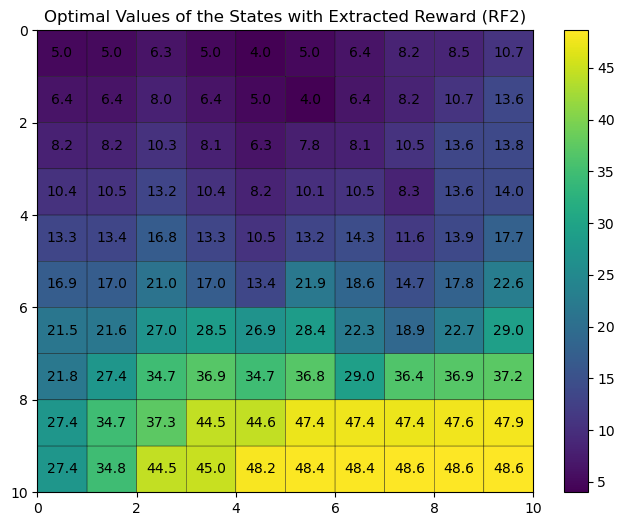

In [27]:
V_agent_2, num_steps_2, _ = optimal_state_value_function(tp, extracted_rwd2, state_space, 
                                                              actions, gamma, epsilon)

# report
print("Number of steps needed to converge: {}\n".format(num_steps_2))
# plot
plt.figure(figsize=(8, 6))
plt.pcolor(V_agent_2.reshape((10, 10)).T, edgecolors='black')
plt.title("Optimal Values of the States with Extracted Reward (RF2)")
for (j, i), label in np.ndenumerate(V_agent_2.reshape((10, 10)).T):
  plt.text(i+0.5, j+0.5, '{:.1f}'.format(label), ha='center', va='center')
plt.gca().invert_yaxis()
plt.colorbar()
plt.savefig(os.path.join(fig_path, "q21.png"))
plt.show()

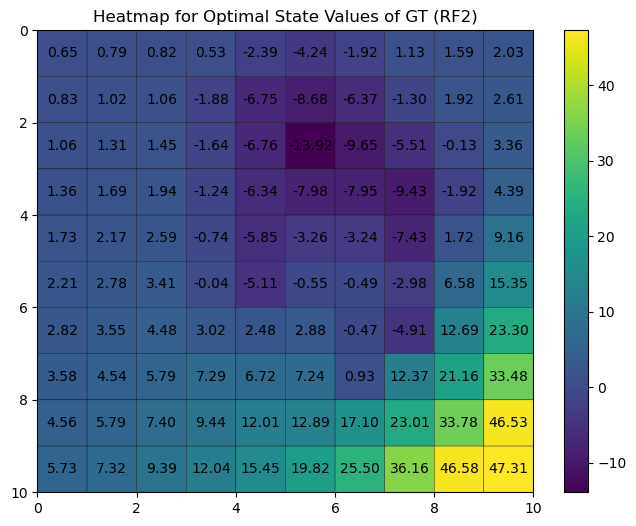

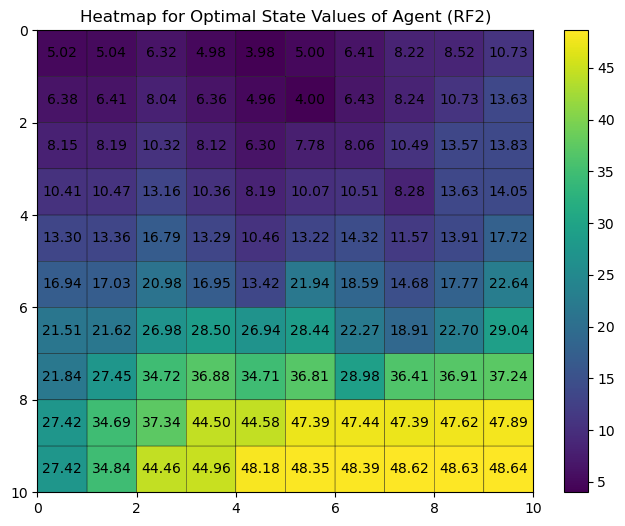

In [23]:
V_agent_2, num_steps_2, _ = optimal_state_value_function(tp, extracted_rwd2, state_space, 
                                                              actions, gamma, epsilon)
# get GT optimal policy from expert [P_opt] based on reward function 1
V_exp, num_steps_exp, P_exp2 = optimal_state_value_function(tp, rwd2, state_space, actions, gamma, epsilon)
# plot
plt.figure(figsize=(8, 6))
plt.pcolor(V_exp.reshape((10, 10)).T, edgecolors='black')
plt.title("Heatmap for Optimal State Values of GT (RF2)")
for (j, i), label in np.ndenumerate(V_exp.reshape((10, 10)).T):
  plt.text(i+0.5, j+0.5, '{:.2f}'.format(label), ha='center', va='center')
plt.gca().invert_yaxis()
plt.colorbar()
plt.savefig(os.path.join(fig_path, "q22_1.png"))
plt.show()

# plot
plt.figure(figsize=(8, 6))
plt.pcolor(V_agent_2.reshape((10, 10)).T, edgecolors='black')
plt.title("Heatmap for Optimal State Values of Agent (RF2)")
for (j, i), label in np.ndenumerate(V_agent_2.reshape((10, 10)).T):
  plt.text(i+0.5, j+0.5, '{:.2f}'.format(label), ha='center', va='center')
plt.gca().invert_yaxis()
plt.colorbar()
plt.savefig(os.path.join(fig_path, "q22_2.png"))
plt.show()

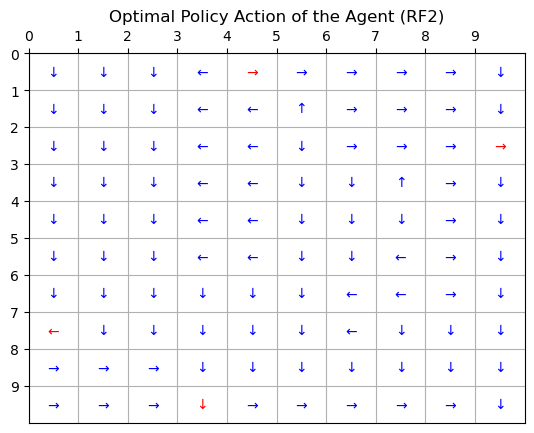

In [46]:
# get optimal policy based on extracted reward

_, _,  P_agent2 = optimal_state_value_function(tp, extracted_rwd2, state_space, 
                                                              actions, gamma, epsilon)

# get optimal policy based on GT reward
rf2_ = RF2().get_reward().flatten("F")
_, _,  P_exp2 = optimal_state_value_function(tp, rf2_, state_space, 
                                                              actions, gamma, epsilon)

# make plot
title = "Optimal Policy Action of the Agent (RF2)"
plot_arrow_diff(P_agent2, P_exp2, state_space, title)
plt.savefig(os.path.join(fig_path, "q23.png"))

In [24]:
def new_value_iter(tp, rwd, state_space, actions, gamma, epsilon):
     # init
    vs = np.zeros(len(state_space))
    delta = np.inf
    num_steps = 0
    prev_vs = np.copy(vs)
    policy = np.zeros(len(state_space))
    # print(actions)
    while delta > epsilon:
        delta = 0
        for i in range(len(state_space)):
            vs[i] = max([np.sum(tp[actions[act]][i]*(rwd + gamma*prev_vs)) for act in actions.keys()])
            delta = max(delta, abs(prev_vs[i] - vs[i]))
        prev_vs = np.copy(vs)
        num_steps += 1

    for i in range(len(state_space)):
        temp = [np.sum(tp[actions[act]][i]*(rwd + gamma*vs)) for act in actions.keys() ]
        # edge case:
        if i != 99:
            if i >= 90:
                temp[3] = -np.inf  # right
            if i <= 9:
                temp[2] = -np.inf  # left
            if i%10 == 0:
                temp[0] = -np.inf  # up
            if i%10 == 9:
                temp[1] = -np.inf  # bottom 
        policy[i] = np.argmax(temp)
    return vs, num_steps, policy
    

new accuracy based on new value iteration algorithm:  0.98


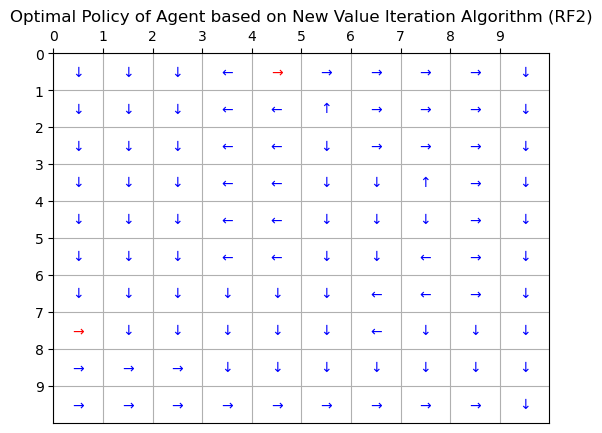

In [26]:
c, D, b, extracted_rwd_25 = irl(P_exp2, tp, R_max, state_space, act_sets, gamma, max_lambda2, actions)

_, _,  P_agent_25 = new_value_iter(tp, extracted_rwd_25, state_space, actions, gamma, epsilon)

acc_25 = accuracy(P_exp2, P_agent_25)
print('new accuracy based on new value iteration algorithm: ', acc_25)

plot_arrow_diff(P_agent_25, P_exp2,
                state_space, "Optimal Policy of Agent based on New Value Iteration Algorithm (RF2)")
plt.savefig(os.path.join(fig_path, "q25.png"))